# Comparison between pychromVAR and chromVAR: Part II

## Run pychromVAR on the example data

Import packages

In [1]:
import anndata
from pyjaspar import jaspardb
import pychromvar as pc
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import seaborn as sns

In [2]:
pc.__version__

'0.0.2'

We can load the data as an anndata object

In [3]:
adata = anndata.read_csv("./counts.csv").transpose()
adata

AnnData object with n_obs × n_vars = 50 × 29269

Before we jump into the running, we need a reference genome for GC bias and motif matching. Here pychromVAR provide a function **get_genome** to
allow you to download genome sequence that we need. If you already have one, then this step can be skipped.

In [4]:
pc.get_genome("hg19", output_dir="./")

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [03:28<00:00,  8.32s/it]


We first extract the sequence information for each peak:

In [5]:
pc.add_peak_seq(adata, genome_file="./hg19.fa")

100%|████████████████████████████████████████████████████████████████████████| 29269/29269 [00:00<00:00, 88935.94it/s]


Then we can estimate GC bias per peak and get the backgrounds

In [6]:
pc.add_gc_bias(adata)
pc.get_bg_peaks(adata)

100%|███████████████████████████████████████████████████████████████████████| 29269/29269 [00:00<00:00, 149184.02it/s]
/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


We next extract TF motifs and perform motif matching to identify TF binding sites

In [7]:
jdb_obj = jaspardb(release='JASPAR2020')
motifs = jdb_obj.fetch_motifs(
    collection = 'CORE',
    tax_group = ['vertebrates'])

pc.match_motif(adata, motifs=motifs, p_value=5e-05)

100%|█████████████████████████████████████████████████████████████████████████| 29269/29269 [00:12<00:00, 2276.23it/s]


With these information, we can estimate TF binding sites accessibility deviations with function **compute_deviations**. This function will return an Anndata object with cells * motifs.

In [8]:
dev = pc.compute_deviations(adata)

2023-01-27 21:11:31 INFO     computing expectation reads per cell and peak...
2023-01-27 21:11:31 INFO     computing observed motif deviations...
2023-01-27 21:11:32 INFO     computing background deviations...


## Compare with chromVAR

We next compare the results between pychromVAR and [chromVAR](https://github.com/GreenleafLab/chromVAR) by calculating the correlation of each cells across all motifs. If these two results are similar, we should observe a high average correlation of all cells.

In [9]:
df_pychromvar = pd.DataFrame(dev.X, 
                             columns=dev.var_names, 
                             index=dev.obs_names)

df_pychromvar.head()

,MA0004.1.Arnt,MA0006.1.Ahr::Arnt,MA0019.1.Ddit3::Cebpa,MA0029.1.Mecom,MA0030.1.FOXF2,MA0031.1.FOXD1,MA0040.1.Foxq1,MA0041.1.Foxd3,MA0051.1.IRF2,MA0057.1.MZF1(var.2),...,MA0090.3.TEAD1,MA0809.2.TEAD4,MA0003.4.TFAP2A,MA0814.2.TFAP2C(var.2),MA1123.2.TWIST1,MA0093.3.USF1,MA0526.3.USF2,MA0748.2.YY2,MA0528.2.ZNF263,MA0609.2.CREM
singles-GM12878-140905-1,1.133281,0.923171,1.146088,-1.006249,-0.732861,-0.775700,0.214353,-0.255420,1.749563,-2.356278,...,-4.070214,-4.889636,1.229542,1.677865,-1.271607,0.099937,-0.004178,2.169295,-2.285279,1.149731
singles-GM12878-140905-2,1.965270,1.240523,0.061824,-1.854125,-0.749239,-1.981010,1.207076,-1.874111,3.280495,-0.835769,...,-2.820434,-4.067576,-0.476055,-0.904521,-1.263341,1.542135,1.745780,1.140910,0.022528,1.950659
singles-GM12878-140905-3,1.760396,0.855670,1.093846,-1.128929,0.338300,-0.956327,0.645882,-0.614129,3.952821,1.381093,...,-3.604757,-5.775802,0.015363,-0.119689,0.564030,0.937728,0.565363,-0.482187,0.124355,2.456688
singles-GM12878-140905-4,-0.373720,3.538571,-0.099967,0.272531,-1.520674,-1.973709,-0.810768,-1.069554,3.271915,2.748999,...,-2.810382,-4.400753,-0.874893,-0.740228,1.379180,-0.437777,-1.105703,2.597081,-2.020135,1.768704
singles-GM12878-140905-5,-0.151169,2.795168,0.667672,-0.941202,0.624300,1.266423,1.801932,-0.349054,2.831177,-0.984145,...,-3.029521,-4.382038,-0.300487,0.089990,-0.726310,-0.062765,-0.118076,-0.127605,-0.445154,-0.099674


In [10]:
df_chromvar = pd.read_csv("./chromvar_z.csv", index_col=0)
df_chromvar.head()

,MA0004.1.Arnt,MA0006.1.Ahr::Arnt,MA0019.1.Ddit3::Cebpa,MA0029.1.Mecom,MA0030.1.FOXF2,MA0031.1.FOXD1,MA0040.1.Foxq1,MA0041.1.Foxd3,MA0051.1.IRF2,MA0057.1.MZF1(var.2),...,MA0090.3.TEAD1,MA0809.2.TEAD4,MA0003.4.TFAP2A,MA0814.2.TFAP2C(var.2),MA1123.2.TWIST1,MA0093.3.USF1,MA0526.3.USF2,MA0748.2.YY2,MA0528.2.ZNF263,MA0609.2.CREM
singles-GM12878-140905-1,0.75,0.84,2.36,-0.97,-1.15,-0.87,-0.42,-0.45,1.39,-2.27,...,-3.93,-4.81,0.36,1.57,-0.49,-0.16,0.05,1.94,-1.17,0.51
singles-GM12878-140905-2,2.34,1.52,0.87,-1.46,-0.79,-1.69,0.51,-1.17,1.87,-1.18,...,-3.63,-4.43,-0.94,-0.81,-1.57,3.01,2.55,0.98,-0.60,1.82
singles-GM12878-140905-3,1.81,0.34,1.16,-1.48,-0.71,0.14,-0.36,-1.38,1.85,1.36,...,-3.59,-4.59,0.18,0.32,-1.00,0.63,0.53,-0.56,-0.18,1.60
singles-GM12878-140905-4,-0.18,3.77,-0.55,-1.50,-2.06,-3.02,-0.56,-0.93,3.62,1.39,...,-3.18,-4.08,-0.12,-0.21,0.44,-0.33,-0.84,2.23,-2.55,2.67
singles-GM12878-140905-5,-0.03,2.49,0.80,-0.17,0.69,2.64,0.54,1.17,1.95,-0.99,...,-3.14,-3.32,0.38,0.07,-0.48,0.49,0.46,-0.61,-0.47,-0.09


In [11]:
correlation = df_pychromvar.corrwith(df_chromvar, axis = 1)

np.mean(correlation)

0.8630324565444885

We can observe that the average correlation is 0.86 which is quite high, indication that our implementation produce highly similar results as the orignial R package does. We can plot the correlations as well.

<AxesSubplot: >

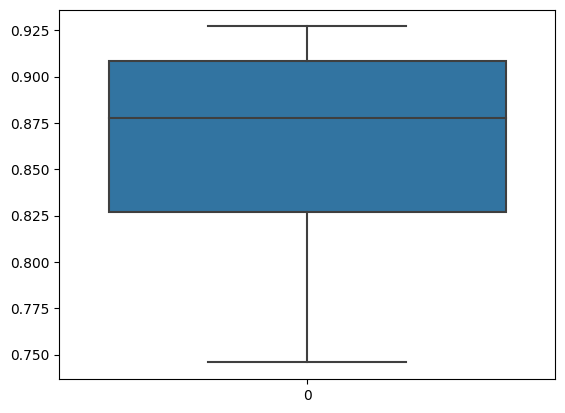

In [12]:
sns.boxplot(data=correlation)

## Where the differences come from?

If you want to figure out why there are some differences between our implementation and chromVAR, let's do some **perturbation** experiments. There are two steps that can probably give rise to different results:

* background peaks identification
* motif matching

For background peaks, here I used a simpler approach based on KNN method after normalizing the GC bias and number of reads for peaks.

For motif matching, the package [MOODS-python](https://pypi.org/project/MOODS-python/) was used, while in chromVAR, the R package[motifmatchr] (https://github.com/GreenleafLab/motifmatchr) was used. Though both packages are based on [MOODS](https://github.com/jhkorhonen/MOODS), there are maybe some differences in details.

We first replace the background peaks using results from chromVAR, and see if the results are changed significantly or not.

load background peaks identified by chromVAR

In [13]:
df_bg_peaks = pd.read_csv("./bg_peaks.csv", index_col=0)

replace the background peaks 

In [14]:
adata.varm['pychromvar_bg_peaks'] = adata.varm['bg_peaks']
adata.varm['bg_peaks'] = df_bg_peaks.to_numpy() - 1

compute deviation again

In [15]:
dev = pc.compute_deviations(adata)

2023-01-27 21:11:46 INFO     computing expectation reads per cell and peak...
2023-01-27 21:11:46 INFO     computing observed motif deviations...
2023-01-27 21:11:46 INFO     computing background deviations...


In [16]:
df_pychromvar = pd.DataFrame(dev.X, 
                             columns=dev.var_names, 
                             index=dev.obs_names)
np.mean(df_pychromvar.corrwith(df_chromvar, axis = 1))

0.8629452586171414

We can see the corrleation kept almost unchanged, meaning that both methods identified similar background peaks.

Let's try to perturb the motif matching results:

In [17]:
df_motif_match = pd.read_csv("./chromvar_motif_match.csv", index_col=0)
adata.varm['motif_match'] = df_motif_match.to_numpy()

In [18]:
dev = pc.compute_deviations(adata)

2023-01-27 21:12:01 INFO     computing expectation reads per cell and peak...
2023-01-27 21:12:01 INFO     computing observed motif deviations...
/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/pychromvar/compute_deviations.py:103: RuntimeWarning: invalid value encountered in divide
  return ((observed - expected) / expected)
2023-01-27 21:12:01 INFO     computing background deviations...
/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/pychromvar/compute_deviations.py:103: RuntimeWarning: invalid value encountered in divide
  return ((observed - expected) / expected)
/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/pychromvar/compute_deviations.py:103: RuntimeWarning: invalid value encountered in divide
  return ((observed - expected) / expected)
/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/pychromvar/compute_deviations.py:103: RuntimeWarning: invalid value encountered in divide
  return (

In [19]:
df_pychromvar = pd.DataFrame(dev.X, 
                             columns=dev.var_names, 
                             index=dev.obs_names)
np.mean(df_pychromvar.corrwith(df_chromvar, axis = 1))

0.9755521523075352

Wooow! We got a 0.978 correlation, almost the exactly same results as chromVAR. So it is the motif matching that causes the diveregence between these two packages.
After checking MOODS-python and motifmatchr, I found that they are actualy based on different version of MOODS, i.e., MOODS-python is based on 1.9.4 while motifmatchr is based on 1.9.3. Another reason could be that the reference genome sequences are slightly different.